In [58]:
import medmnist
from medmnist import INFO, Evaluator

import torch
import torch.nn as nn 
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

from tqdm import tqdm
import numpy as np

In [59]:
# data_flag = "dermamnist"
# data_flag = "bloodmnist"
# data_flag = "organamnist"
# data_flag = "organcmnist"
data_flag = "organsmnist"
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
num_channels = info['n_channels']
num_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

print(info)
print(DataClass)

{'python_class': 'OrganCMNIST', 'description': 'The OrganCMNIST is based on 3D computed tomography (CT) images from Liver Tumor Segmentation Benchmark (LiTS). It is renamed from OrganMNIST_Coronal (in MedMNIST v1) for simplicity. We use bounding-box annotations of 11 body organs from another study to obtain the organ labels. Hounsfield-Unit (HU) of the 3D images are transformed into gray-scale with an abdominal window. We crop 2D images from the center slices of the 3D bounding boxes in coronal views (planes). The images are resized into 1×28×28 to perform multi-class classification of 11 body organs. 115 and 16 CT scans from the source training set are used as training and validation set, respectively. The 70 CT scans from the source test set are treated as the test set.', 'url': 'https://zenodo.org/record/6496656/files/organcmnist.npz?download=1', 'MD5': '0afa5834fb105f7705a7d93372119a21', 'task': 'multi-class', 'label': {'0': 'bladder', '1': 'femur-left', '2': 'femur-right', '3': 'h

In [60]:
#preprocessing
data_transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Normalize(mean=[.5], std=[.5]) #output[channel] = (input[channel] - mean[channel]) / std[channel]
])

#loading
train_dataset = DataClass(split='train', transform=data_transform, download=download)
test_dataset = DataClass(split='test', transform=data_transform, download=download)

#encapsulating
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

# print(train_dataset)
# print("===============")
# print(test_dataset)

Using downloaded and verified file: /Users/carlosgil/.medmnist/organcmnist.npz
Using downloaded and verified file: /Users/carlosgil/.medmnist/organcmnist.npz


/Users/carlosgil/.pyenv/versions/3.10.3/lib/python3.10/site-packages/medmnist/utils.py:25: FutureWarning: `multichannel` is a deprecated argument name for `montage`. It will be removed in version 1.0. Please use `channel_axis` instead.
  montage_arr = skimage_montage(sel_img, multichannel=(n_channels == 3))


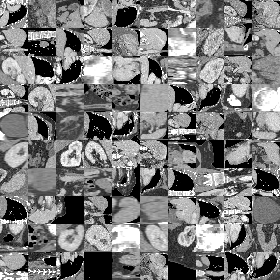

In [61]:
#visualization
train_dataset.montage(length=10)

In [62]:
#Define CNN model

class Net(nn.Module):
  def __init__(self, in_channels, num_classes):
    super(Net, self).__init__()

    self.layer1 = nn.Sequential(
      nn.Conv2d(in_channels, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU() #activation function
    )

    self.layer2 = nn.Sequential(
      nn.Conv2d(16, 16, kernel_size=3),
      nn.BatchNorm2d(16),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.layer3 = nn.Sequential(
      nn.Conv2d(16, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer4 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )

    self.layer5 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2, stride=2)
    )

    self.fc = nn.Sequential(
      nn.Linear(64 * 4 * 4, 128),
      nn.ReLU(),
      nn.Linear(128, 128),
      nn.ReLU(),
      nn.Linear(128, num_classes)
    )

  def forward(self, x):
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)
    x = self.layer4(x)
    x = self.layer5(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)
    return x

model = Net(in_channels=num_channels, num_classes=num_classes)

# define loss function and optimizer
if task == "multi-label, binary-class":
    criterion = nn.BCEWithLogitsLoss()
else:
    criterion = nn.CrossEntropyLoss()
    
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [63]:
#model
for _ in range(NUM_EPOCHS):
    train_correct = 0
    train_total = 0
    test_correct = 0
    test_total = 0
    
    model.train()
    
    for inputs, targets in tqdm(train_loader):
        # forward + backward + optimize
        optimizer.zero_grad()
        outputs = model(inputs)
        
        if task == 'multi-label, binary-class':
            targets = targets.to(torch.float32)
            loss = criterion(outputs, targets)
        else:
            targets = targets.squeeze().long()
            loss = criterion(outputs, targets)
        
        loss.backward()
        optimizer.step()

100%|██████████| 102/102 [00:07<00:00, 12.83it/s]


In [64]:
# evaluation

def test(split):
    model.eval()
    y_true = torch.tensor([])
    y_score = torch.tensor([])
    
    data_loader = train_loader_at_eval if split == 'train' else test_loader

    with torch.no_grad():
        for inputs, targets in data_loader:
            outputs = model(inputs)

            if task == 'multi-label, binary-class':
                targets = targets.to(torch.float32)
                outputs = outputs.softmax(dim=-1)
            else:
                targets = targets.squeeze().long()
                outputs = outputs.softmax(dim=-1)
                targets = targets.float().resize_(len(targets), 1)

            y_true = torch.cat((y_true, targets), 0)
            y_score = torch.cat((y_score, outputs), 0)

        y_true = y_true.numpy()
        y_score = y_score.detach().numpy()
        
        evaluator = Evaluator(data_flag, split)
        metrics = evaluator.evaluate(y_score)
    
        print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

    return (y_true, y_score)
        
print('==> Evaluating ...')
y_true_train, y_score_train = test('train')
y_true_test, y_score_test = test('test')

==> Evaluating ...
train  auc: 0.950  acc:0.710
test  auc: 0.923  acc:0.634


In [65]:
"""
def getAUC(y_true, y_score, task):
    '''AUC metric.
    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1
    :param y_score: the predicted score of each class,
    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1
    :param task: the task of current dataset
    '''
"""

"\ndef getAUC(y_true, y_score, task):\n    '''AUC metric.\n    :param y_true: the ground truth labels, shape: (n_samples, n_labels) or (n_samples,) if n_labels==1\n    :param y_score: the predicted score of each class,\n    shape: (n_samples, n_labels) or (n_samples, n_classes) or (n_samples,) if n_labels==1 or n_classes==1\n    :param task: the task of current dataset\n    '''\n"

In [66]:
from netcal.scaling import TemperatureScaling

# ground_truth, confidences = y_true_test[:,0], y_score_test
ground_truth, confidences = y_true_train[:,0], y_score_train

temperature = TemperatureScaling()
temperature.fit(confidences, ground_truth)
calibrated = temperature.transform(confidences)

In [71]:
from netcal.metrics import ECE

n_bins = 100

ece = ECE(n_bins)

uncalibrated_score = ece.measure(confidences,ground_truth)
calibrated_score = ece.measure(calibrated,ground_truth)

print(f'Uncalibrated ECE: {uncalibrated_score}')
print(f'Calibrated ECE: {calibrated_score}')

Uncalibrated ECE: 0.1596077547076499
Calibrated ECE: 0.05357170996528408


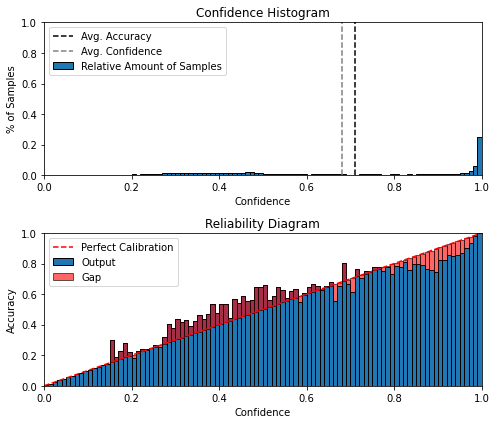

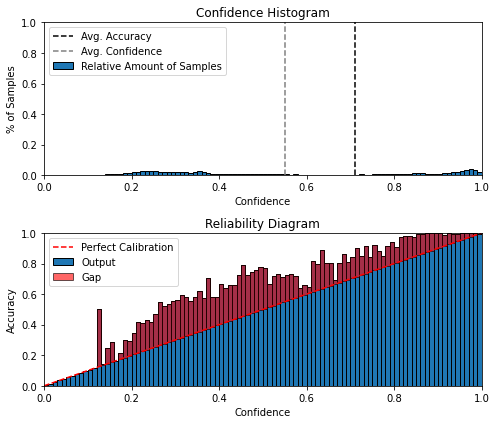

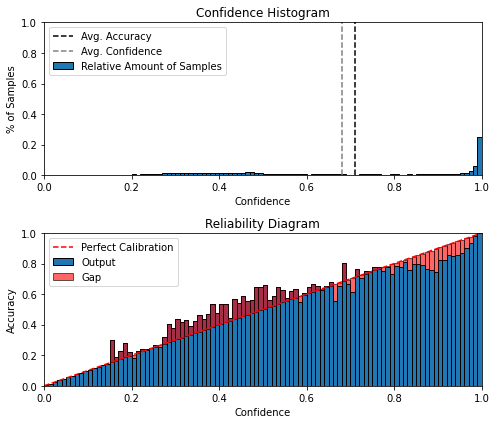

In [72]:
from netcal.presentation import ReliabilityDiagram

n_bins = 100

diagram = ReliabilityDiagram(n_bins)
diagram.plot(confidences, ground_truth)  # visualize miscalibration of uncalibrated
diagram.plot(calibrated, ground_truth)   # visualize miscalibration of calibrated